<a href="https://colab.research.google.com/github/aashrithresearch/endometrial-adenocarcinoma/blob/main/models/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/histopathological image dataset for ET'

In [ ]:
print(os.listdir(path))

['EA', 'Non EA', 'feature_dict.p', 'lsh.p']


In [ ]:
item_tfms = [Resize(299)]
batch_tfms = [*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

dls = dblock.dataloaders(path)

In [ ]:
train_ds = dls.train_ds
dls = dblock.dataloaders(path)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Non EA: 2222
EA: 422


In [ ]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])

print("Number of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the validation set:
Non EA: 548
EA: 113


In [ ]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

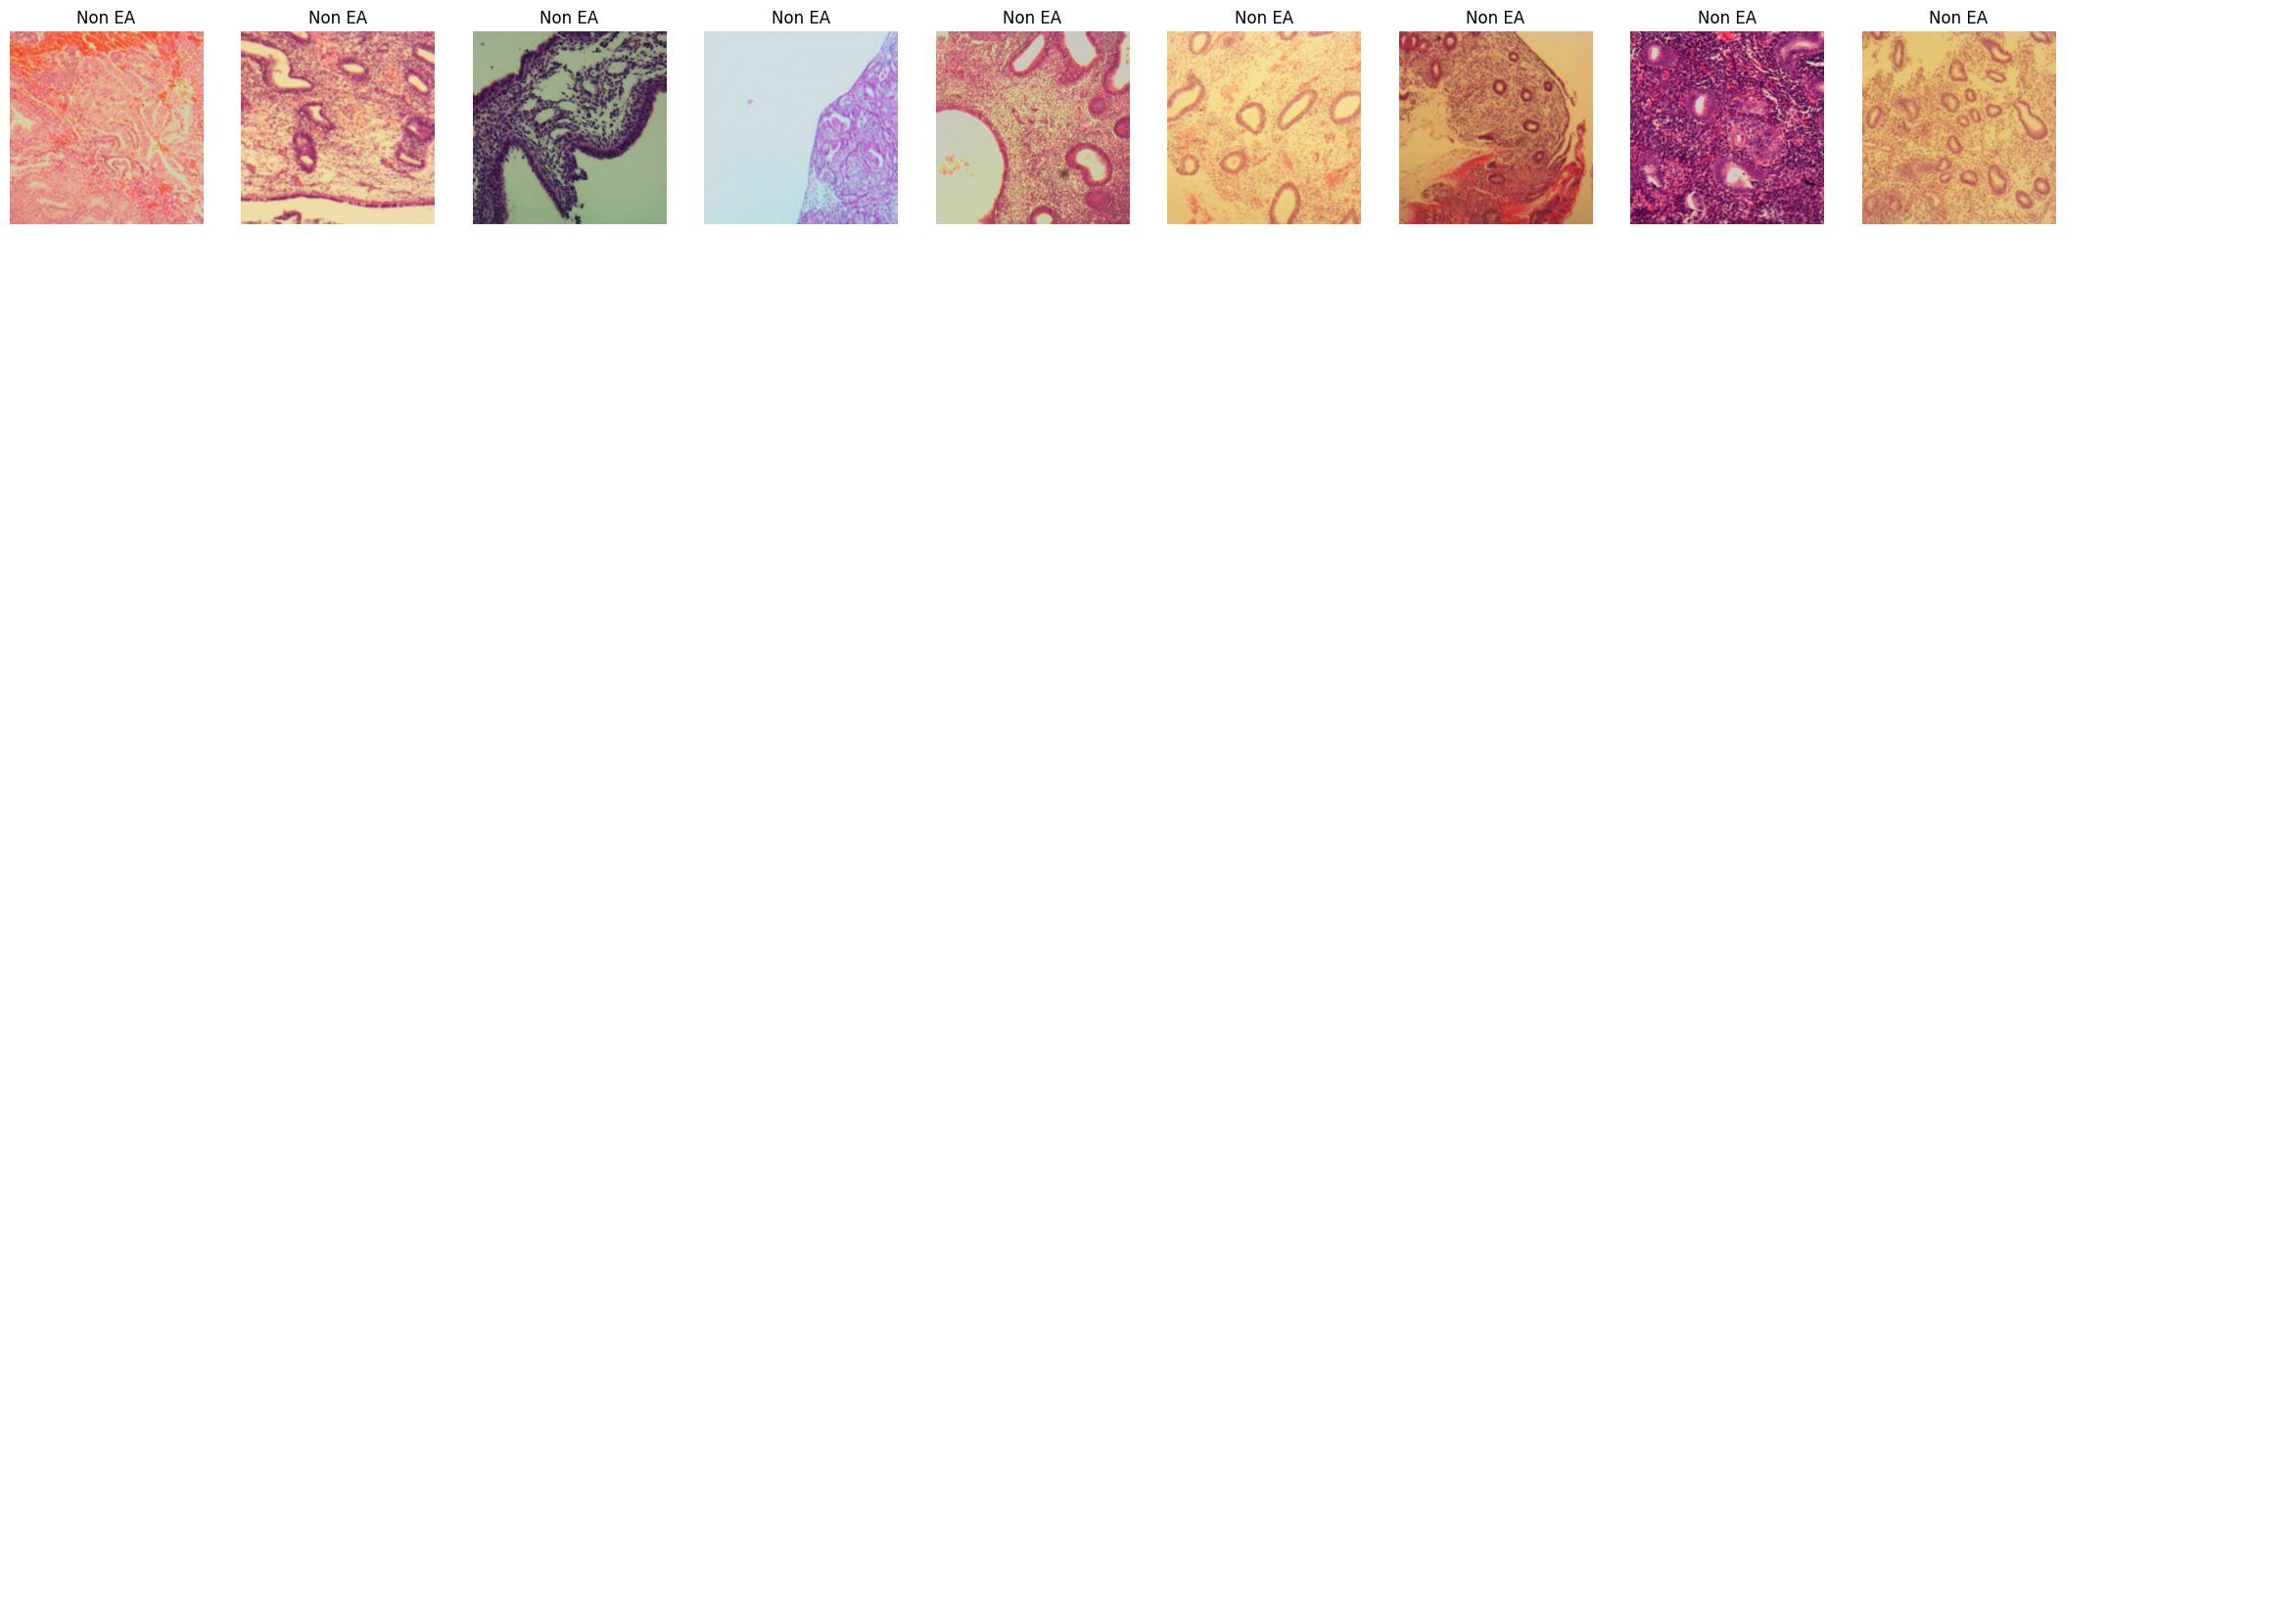

In [ ]:
dls.show_batch(nrows=nrows, ncols=10)

In [ ]:
metrics = [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
]

In [ ]:
learnv3 = vision_learner(dls, alexnet, metrics=metrics, cbs=[GradientAccumulation(n_acc=16)], loss_func=FocalLoss(), opt_func=Adam).to_fp16()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 177MB/s]


In [ ]:
learnv3.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.819055,0.239780,0.754917,0.688101,0.813554,0.693960,01:44
1,0.576229,0.140621,0.853253,0.756630,0.858811,0.787338,00:30
2,0.396537,0.095694,0.886536,0.795854,0.889421,0.828736,00:30
3,0.271418,0.074501,0.916793,0.852513,0.854984,0.853740,00:31
4,0.200657,0.074395,0.916793,0.849861,0.862008,0.855746,00:30
5,0.163768,0.070321,0.927383,0.868668,0.878932,0.873674,00:30
6,0.134883,0.060697,0.939486,0.893256,0.893256,0.893256,00:30
7,0.116462,0.061308,0.931921,0.879013,0.881669,0.880333,00:30
8,0.102653,0.061183,0.933434,0.882582,0.882582,0.882582,00:30
9,0.093911,0.059507,0.934947,0.886214,0.883494,0.884846,00:30


In [ ]:
learnv3.save('alexnet stage1')

Path('models/alexnet stage1.pth')

SuggestedLRs(valley=9.120108734350652e-05)

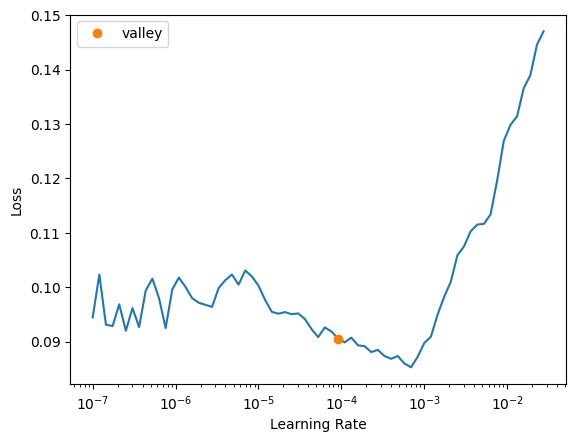

In [ ]:
learnv3.unfreeze()
learnv3.lr_find()

In [ ]:
learnv3.fit_one_cycle(15, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.081726,0.059932,0.936460,0.886033,0.891431,0.888699,00:31
1,0.092158,0.059231,0.937973,0.889613,0.892344,0.890970,00:30
2,0.085214,0.058316,0.937973,0.887741,0.895856,0.891725,00:30
3,0.084956,0.056561,0.939486,0.907479,0.872182,0.888492,00:31
4,0.085957,0.059755,0.939486,0.907479,0.872182,0.888492,00:31
5,0.084818,0.060410,0.934947,0.902817,0.858908,0.878752,00:30
6,0.085697,0.059673,0.940998,0.909011,0.876607,0.891687,00:31
7,0.081210,0.057979,0.945537,0.913549,0.889881,0.901127,00:31
8,0.078401,0.056937,0.948563,0.919210,0.895218,0.906620,00:31
9,0.082737,0.058329,0.939486,0.910322,0.868670,0.887642,00:31


In [ ]:
learnv3.save('alexnet stage2')

Path('models/alexnet stage2.pth')

SuggestedLRs(valley=0.00010964782268274575)

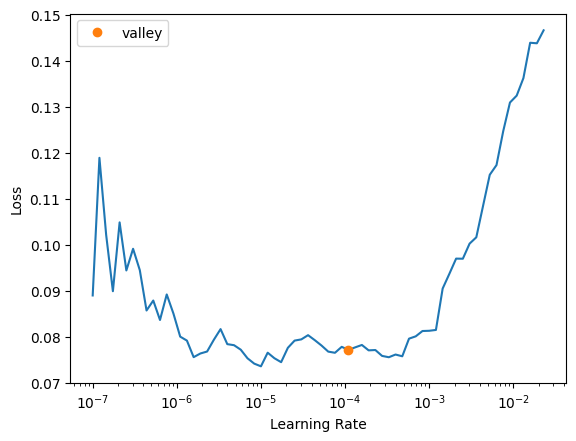

In [ ]:
learnv3.unfreeze()
learnv3.lr_find()

In [ ]:
learnv3.fit_one_cycle(15, 1e-6)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.074333,0.056831,0.944024,0.914808,0.881944,0.897242,00:31
1,0.072229,0.056169,0.944024,0.900213,0.903018,0.901607,00:31
2,0.073092,0.056645,0.940998,0.891126,0.904706,0.897711,00:30
3,0.075612,0.056333,0.945537,0.903931,0.903931,0.903931,00:32
4,0.073599,0.056552,0.947050,0.912472,0.897818,0.904920,00:31
5,0.077796,0.055426,0.945537,0.913549,0.889881,0.901127,00:30
6,0.073038,0.055937,0.940998,0.892969,0.901193,0.897006,00:31
7,0.072790,0.055769,0.944024,0.902339,0.899506,0.900914,00:31
8,0.075048,0.056151,0.940998,0.906341,0.880119,0.892491,00:31
9,0.075938,0.056151,0.944024,0.906939,0.892481,0.899487,00:31


In [ ]:
learnv3.save('alexnet stage3')

Path('models/alexnet stage3.pth')

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

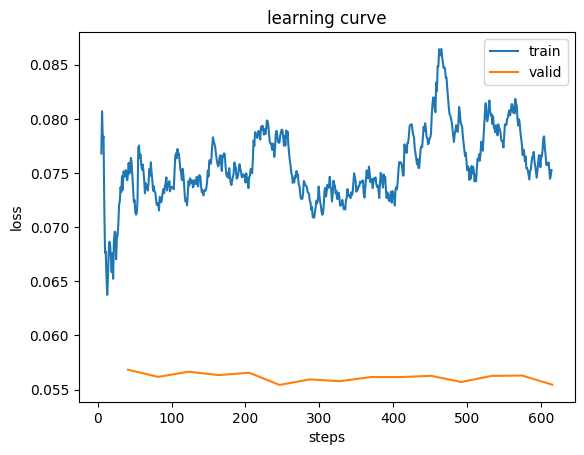

In [ ]:
learnv3.recorder.plot_loss()